In [63]:
import sys
import degiroapi
from degiroapi.product import Product
from degiroapi.order import Order
from degiroapi.utils import pretty_json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import getpass
import json
import matplotlib.pyplot as plt
import seaborn as sb
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib.request
import csv
import chromedriver_binary
pd.options.display.float_format = '{:.0f}'.format

In [59]:
!{sys.executable} -m pip install string

ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


### API Connection

In [162]:
#Create safe method for password
password = getpass.getpass('YourPassword')
print('Your password is: ' + password)

YourPassword 


In [6]:
# login to Degiro
degiro = degiroapi.DeGiro()
degiro.login("RobinHocepied", password)

{'data': {'id': 501261,
  'intAccount': 11025519,
  'loggedInPersonId': 503705,
  'clientRole': 'active',
  'effectiveClientRole': 'active',
  'contractType': 'PRIVATE',
  'username': 'RobinHocepied',
  'displayName': 'ROBIN JEAN C HOCEPIED',
  'email': 'robinhocepied@gmail.com',
  'firstContact': {'firstName': 'ROBIN JEAN C',
   'lastName': 'HOCEPIED',
   'displayName': 'ROBIN JEAN C HOCEPIED',
   'nationality': 'BE',
   'gender': 'MALE',
   'dateOfBirth': '1993-05-24',
   'placeOfBirth': 'Verviers',
   'countryOfBirth': 'BE'},
  'address': {'streetAddress': 'Rue Gérard',
   'streetAddressNumber': '64',
   'streetAddressExt': 'Etterbeek',
   'zip': '1040',
   'city': 'Bruxelles',
   'country': 'BE'},
  'cellphoneNumber': '+32471991561',
  'locale': 'fr_BE',
  'language': 'fr',
  'culture': 'BE',
  'displayLanguage': 'fr',
  'bankAccount': {'bankAccountId': 508936,
   'bic': 'CREGBEBBXXX',
   'iban': 'BE58732028811879',
   'status': 'VERIFIED'},
  'flatexBankAccount': {'bic': 'BIWBDE33

### Get Portfolio positions

In [7]:
portfolio = degiro.getdata(degiroapi.Data.Type.PORTFOLIO, True)
portfolio_df = pd.DataFrame(portfolio)
portfolio_df.head(5)

,id,positionType,size,price,value,breakEvenPrice
0,18343191,PRODUCT,1.0,38.42,33.974806,36.710000
1,19790636,PRODUCT,20.0,3.15,55.710900,5.210000
2,18333971,PRODUCT,1.0,18.98,16.784014,28.311741
3,19433248,PRODUCT,10.0,1.94,17.155420,3.892857
4,16204538,PRODUCT,401.0,2.27,804.951761,5.211147


In [8]:
#Delete CASH in positionType
i = portfolio_df[(portfolio_df.positionType == "CASH")].index
portfolio_df.drop(i, inplace=True)

In [9]:
portfolio_df['pct_of_total'] = ((portfolio_df['value']/portfolio_df['value'].sum())*100).round(2)
portfolio_df.head()

,id,positionType,size,price,value,breakEvenPrice,pct_of_total
0,18343191,PRODUCT,1.0,38.42,33.974806,36.710000,0.34
1,19790636,PRODUCT,20.0,3.15,55.710900,5.210000,0.56
2,18333971,PRODUCT,1.0,18.98,16.784014,28.311741,0.17
3,19433248,PRODUCT,10.0,1.94,17.155420,3.892857,0.17
4,16204538,PRODUCT,401.0,2.27,804.951761,5.211147,8.04


In [10]:
portfolio_df.describe()

,size,price,value,breakEvenPrice,pct_of_total
count,54.000000,54.000000,54.000000,54.000000,54.000000
mean,17.666667,68.534259,185.298887,92.118754,1.851852
std,61.032933,70.017661,477.502981,95.733025,4.772557
min,1.000000,1.390000,5.403073,1.380000,0.050000
25%,1.000000,17.007500,42.470791,24.639018,0.425000
50%,1.000000,42.590000,100.332678,65.516190,1.005000
75%,4.750000,109.785000,162.063450,123.299584,1.622500
max,401.000000,307.000000,3498.741793,405.045937,34.970000


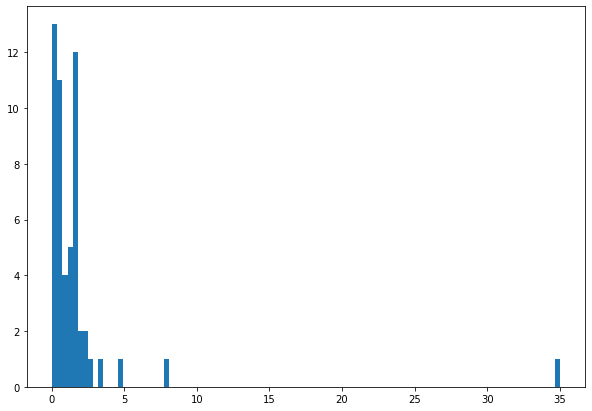

In [11]:
# Portfolio weights

# Figure Size
fig = plt.figure(figsize =(10, 7))
 
plt.hist(portfolio_df.pct_of_total,  bins=100)
plt.show() 

<AxesSubplot:xlabel='pct_of_total'>

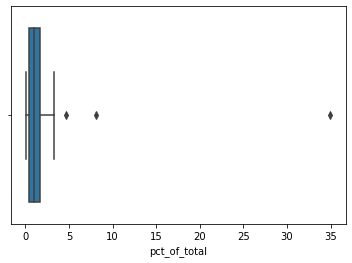

In [12]:
#Boxplot
sb.boxplot(x = 'pct_of_total', data = portfolio_df, showfliers = True)

### Get Stock Names

In [13]:
stock_names = [degiro.product_info(x) for x in portfolio_df['id'].values]
stock_names_df = pd.DataFrame(stock_names)

In [14]:
stock_names_df = stock_names_df[['id','name','symbol']]
stock_names_df.head()

,id,name,symbol
0,18343191,Goodrx Holdings Inc,GDRX
1,19790636,FIELD TRIP HEALTH LTD. - COMMON SHARES,FTRP
2,18333971,Palantir Technologies Inc,PLTR
3,19433248,FLORA GROWTH CORP. - COMMON STOCK,FLGC
4,16204538,Douyu International Holdings Ltd,DOYU


### Merge Portfolio and Stock Names

In [15]:
portfolio_stock_df = portfolio_df.merge(stock_names_df, how='left', on='id')

In [16]:
portfolio_stock_df.head()

,id,positionType,size,price,value,breakEvenPrice,pct_of_total,name,symbol
0,18343191,PRODUCT,1.0,38.42,33.974806,36.710000,0.34,Goodrx Holdings Inc,GDRX
1,19790636,PRODUCT,20.0,3.15,55.710900,5.210000,0.56,FIELD TRIP HEALTH LTD. - COMMON SHARES,FTRP
2,18333971,PRODUCT,1.0,18.98,16.784014,28.311741,0.17,Palantir Technologies Inc,PLTR
3,19433248,PRODUCT,10.0,1.94,17.155420,3.892857,0.17,FLORA GROWTH CORP. - COMMON STOCK,FLGC
4,16204538,PRODUCT,401.0,2.27,804.951761,5.211147,8.04,Douyu International Holdings Ltd,DOYU


### Web Scraping Yahoo Finance

https://finance.yahoo.com/quote/GDRX?p=GDRX

In [159]:
var = 'PLTR'
var_1 = var + '/' 
url='https://finance.yahoo.com/quote/{0}'.format(var_1)
response = requests.get(url)

In [161]:
soup = BeautifulSoup(response.text, 'html.parser')
print(soup.title)

<title>Palantir Technologies Inc. (PLTR) Stock Price, News, Quote &amp; History - Yahoo Finance</title>


In [104]:
sector_industry = [entry.text for entry in soup.find_all('span', {'class':'Fw(600)'})]

In [137]:
sector =[]

In [138]:
for entry in soup.find_all('span', {'class':'Fw(600)'}):
    if len(entry.text)>3 and entry.text != 'Morningstar':
        sector.append(entry.text)
    

In [139]:
sector

['Technology', 'Software—Infrastructure', '2,733']

In [133]:
sector[0]

'Morningstar'

### Portfolio Analysis - Unrealized Gains

##### Ideas: 
1. Industry
2. IPO 
3. Last 12 months return 
4. ...

In [17]:
portfolio_stock_df['unrealized_gains'] = round((portfolio_stock_df['price']-portfolio_stock_df['breakEvenPrice'])*portfolio_stock_df['size'],2)

In [18]:
#Total Value of Portfolio
round(portfolio_stock_df['value'].sum(),2)

10006.14

In [19]:
#Total Value of Unrealized Gains
round(portfolio_stock_df['unrealized_gains'].sum(),2)

-5205.9

In [21]:
#Assign Quantiles to the Stocks % of total
quantiles = pd.qcut(portfolio_stock_df['pct_of_total'], 4, labels=False)
portfolio_stock_df = portfolio_stock_df.assign(quantile=quantiles.values)
portfolio_stock_df.head()

,id,positionType,size,price,value,breakEvenPrice,pct_of_total,name,symbol,unrealized_gains,quantile
0,18343191,PRODUCT,1.0,38.42,33.974806,36.710000,0.34,Goodrx Holdings Inc,GDRX,1.71,0
1,19790636,PRODUCT,20.0,3.15,55.710900,5.210000,0.56,FIELD TRIP HEALTH LTD. - COMMON SHARES,FTRP,-41.20,1
2,18333971,PRODUCT,1.0,18.98,16.784014,28.311741,0.17,Palantir Technologies Inc,PLTR,-9.33,0
3,19433248,PRODUCT,10.0,1.94,17.155420,3.892857,0.17,FLORA GROWTH CORP. - COMMON STOCK,FLGC,-19.53,0
4,16204538,PRODUCT,401.0,2.27,804.951761,5.211147,8.04,Douyu International Holdings Ltd,DOYU,-1179.40,3


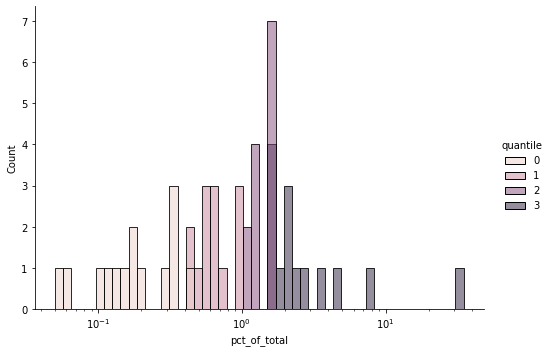

In [22]:
#Overlayed Distribution by quantile
sb.displot(
  data=portfolio_stock_df,
  x="pct_of_total",
  hue="quantile",
  kind="hist",
  aspect=1.4,
  log_scale=10,
  bins=50
)

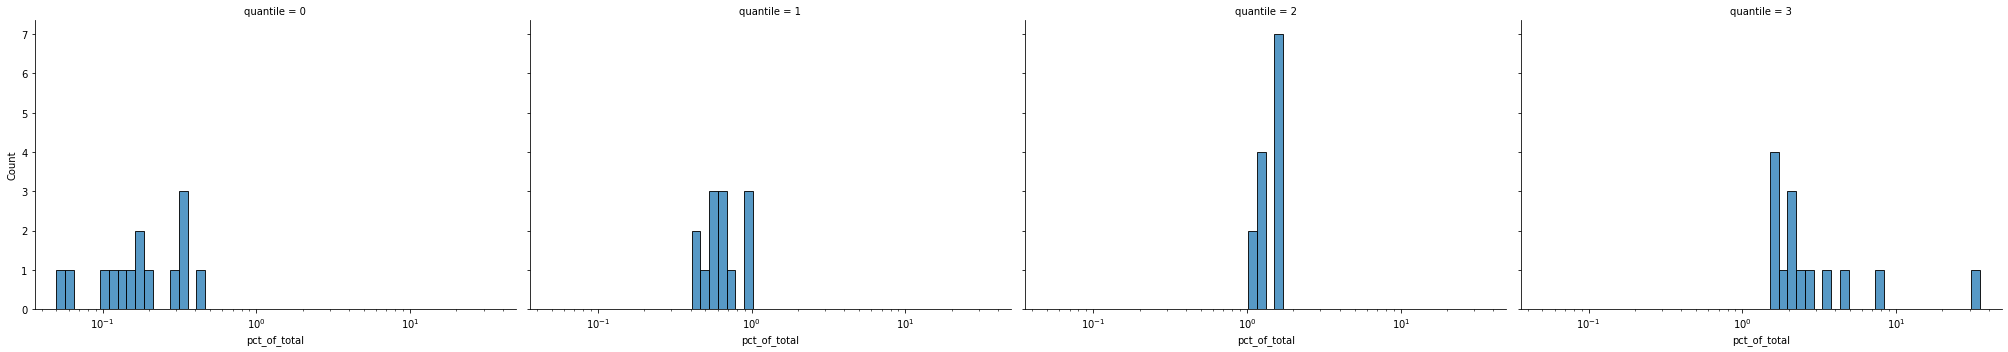

In [23]:
#Distributions by quantile
sb.displot(
  data=portfolio_stock_df,
  x="pct_of_total",
  col="quantile",
  kind="hist",
  aspect=1.4,
  log_scale=10,
  bins=50
)

### Transactions

In [24]:
transactions = degiro.transactions(datetime(2018, 1, 1), datetime.now())

In [25]:
transactions_df = pd.DataFrame(transactions)

In [26]:
transactions_df.describe()

,id,productId,price,quantity,total,orderTypeId,fxRate,totalInBaseCurrency,feeInBaseCurrency,totalPlusFeeInBaseCurrency,transactionTypeId
count,8.760000e+02,8.760000e+02,876.000000,876.000000,876.000000,870.000000,876.000000,876.000000,852.000000,876.000000,876.000000
mean,2.125192e+08,1.178274e+07,112.263895,1.089041,11.861818,1.806897,1.219161,6.367550,-0.761185,5.627219,0.719178
std,4.353589e+07,6.091382e+06,173.450285,1205.582333,1503.419313,0.591033,1.176719,1227.270217,1.013625,1227.244843,8.668427
min,1.534398e+08,2.554290e+05,0.020000,-30000.000000,-8075.200000,0.000000,0.000000,-6598.463588,-9.070000,-6599.223588,0.000000
25%,1.658811e+08,5.586795e+06,27.525000,-5.000000,-587.575000,2.000000,1.108708,-511.433991,-0.592500,-511.943991,0.000000
50%,2.074266e+08,1.465250e+07,65.955000,1.000000,-103.385000,2.000000,1.131118,-87.057732,-0.530000,-87.557732,0.000000
75%,2.388252e+08,1.608294e+07,146.092500,10.000000,480.900000,2.000000,1.180780,407.109835,-0.510000,406.669835,0.000000
max,3.213756e+08,1.981116e+07,2293.590000,15000.000000,11467.000000,2.000000,10.767056,9407.389091,-0.010000,9406.559091,108.000000


In [27]:
transactions_df.head()

,id,productId,date,buysell,price,quantity,total,orderTypeId,counterParty,transfered,fxRate,totalInBaseCurrency,feeInBaseCurrency,totalPlusFeeInBaseCurrency,transactionTypeId,tradingVenue
0,153439824,13433777,2019-04-04T15:30:00+02:00,B,21.98,15,-329.70,2.0,MK,False,1.120920,-294.135583,-0.55,-294.685583,0,XNYS
1,153514251,1156277,2019-04-04T17:34:27+02:00,B,84.76,5,-423.80,2.0,MK,False,1.122221,-377.651951,-0.52,-378.171951,0,IEXG
2,153946118,1135199,2019-04-10T15:39:10+02:00,B,178.82,1,-178.82,2.0,MK,False,1.124323,-159.050799,-0.50,-159.550799,0,EDGA
3,153946119,1135199,2019-04-10T15:39:10+02:00,B,178.79,2,-357.58,2.0,MK,False,1.124323,-318.051624,-0.01,-318.061624,0,XNAS
4,154053075,1140987,2019-04-11T15:33:43+02:00,B,90.55,6,-543.30,2.0,MK,False,1.126525,-482.287253,-0.52,-482.807253,0,BATS


### Transactions Analysis

[]


In [ ]:
import degiroapi
from degiroapi.product import Product
from degiroapi.order import Order
from degiroapi.utils import pretty_json

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# login
degiro = degiroapi.DeGiro()
degiro.login("RobinHocepied", "Jeancharles146124%")

  
# getting realtime and historical data from a stock
products = degiro.search_products('PINS')
high=[]
nb = []


for x in range(2):
        realprice = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.Max)  
        rp = realprice[0]['data']['lastPrice']
        print(high)
    
        #time.sleep(60)
        realprice1 = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.Max)  
        rp1 = realprice1[0]['data']['lastPrice']
        if rp1 > rp:
            rp3 = 0.97*rp1
            high.append(rp1*0.97)
            nb.append(1)
            degiro.buyorder(Order.Type.LIMIT, Product(products[0]).id, 3, 1, round(rp3,2))
            if len(nb) == 0: 
                break
            break
        break
            
        print(high)
        print(nb)
       
